## Metric Reconstruction  
Chapter 10. 3D Reconstruction of Cameras and Structure



In [1]:
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import glob
from utils import *
%matplotlib notebook

In [2]:
IMG_DIR = '/home/seonwookim/Projects/GIST-ADIP/data/'

In [3]:
images = [each for each in glob.glob(IMG_DIR + "IMG*.jpg")]

In [4]:
im = mplimg.imread(images[2])

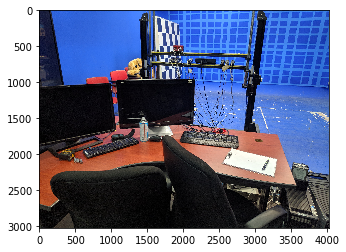

In [5]:
plt.imshow(im)

In [6]:
im2 = mplimg.imread(images[3])

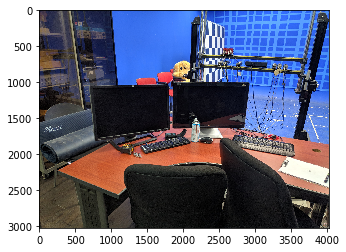

In [7]:
plt.imshow(im2)

In [8]:
nLinePairs = 2

In [ ]:
imA, HA = rectifyAffineF(im, nLinePairs)

/home/seonwookim/.conda/envs/adip/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [1]:
import matplotlib.image as mplimg
import os
import sys
from utils import *

In [7]:
nLinePairs = 2

In [ ]:
imgPath = sys.argv[1];
fileparts = os.path.splitext(imgPath)
if fileparts[1] == '':
    fileparts = (fileparts[0], '.png')
imgPath = fileparts[0] + fileparts[1];
im = mplimg.imread(imgPath)

In [ ]:
imA, HA = rectifyAffineF(im, nLinePairs)

/home/seonwookim/.conda/envs/adip/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
